<a href="https://colab.research.google.com/github/laribar/SmartAITraderBot/blob/main/Bot_Funcional_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta
!pip install yfinance
!pip install xgboost

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=091ec1d14a9cbcf90751d386803aefa0a7b697ff335e0ae862d633d6278bf87e
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [15]:
# ====================================================
# 1. IMPORTAÇÕES
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import requests
import time  # Para usar time.sleep()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
XGBClassifier(
    n_estimators=200,
    max_depth=4,                 # menor profundidade = menos overfitting
    subsample=0.8,               # usa 80% dos dados por árvore
    colsample_bytree=0.8,        # usa 80% das features por árvore
    learning_rate=0.05,          # suaviza o aprendizado
    early_stopping_rounds=10,    # para de treinar se não melhorar
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ====================================================
# BLOCO 1 - CONFIGURAÇÃO DE PASTAS E IMPORTS EXTRA
# ====================================================
import os
import joblib
from tensorflow.keras.models import load_model

# Criar pasta onde os modelos serão salvos
os.makedirs("/content/models", exist_ok=True)
# ====================================================
# BLOCO 2 - SALVAR E CARREGAR MODELOS TREINADOS
# ====================================================
def get_model_path(asset, interval, model_type="xgb"):
    asset_clean = asset.replace("-", "")
    ext = "joblib" if model_type == "xgb" else "h5"
    return f"/content/models/{model_type}_model_{asset_clean}_{interval}.{ext}"

# --- XGBoost ---
def save_xgb_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    joblib.dump(model, path)
    print(f"💾 Modelo XGBoost salvo em: {path}")

def load_xgb_model(asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    if os.path.exists(path):
        print(f"📂 Modelo XGBoost carregado de: {path}")
        return joblib.load(path)
    return None

# --- LSTM ---
def save_lstm_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="lstm")
    model.save(path)
    print(f"💾 Modelo LSTM salvo em: {path}")

def load_lstm_model(asset, interval, data=None, window_size=20):
    from tensorflow.keras.models import load_model

    path = get_model_path(asset, interval, model_type="lstm")
    if os.path.exists(path):
        print(f"📂 Modelo LSTM encontrado em: {path}")
        try:
            model = load_model(path)
            print(f"✅ Modelo LSTM carregado com sucesso para {asset} ({interval})")
        except Exception as e:
            print(f"❌ Falha ao carregar modelo LSTM: {e}")
            return None

        model.window_size = window_size

        if data is not None:
            try:
                _, _, scaler = prepare_lstm_data(data, window_size=window_size)
                model.scaler = scaler
            except Exception as e:
                print(f"⚠️ Erro ao aplicar scaler ao LSTM carregado: {e}")
                model.scaler = None
        else:
            print("⚠️ Atenção: LSTM carregado sem dados para gerar o scaler!")
            model.scaler = None

        return model
    else:
        print(f"🚫 Modelo LSTM NÃO encontrado em: {path}")
        return None





# ====================================================
# 2. CONFIGURAÇÕES
# ====================================================
ASSETS = ["BTC-USD"] #, "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "AVAX-USD", "AAVE-USD", "DOT-USD", "NEAR-USD", "ADA-USD"


TIMEFRAMES = [
    {"interval": "15m", "period": "30d", "atr": 0.02},
    {"interval": "1h", "period": "90d", "atr": 0.03},
    {"interval": "1d", "period": "1000d", "atr": 0.05}
]

TELEGRAM_TOKEN = "8044593190:AAFtUWYHd3uqd-AtQi3uqg42F9G6uV95v8k"
TELEGRAM_CHAT_ID = "-4744645054"

# ====================================================
# 3. COLETA DE DADOS
# ====================================================
def get_stock_data(asset, interval="15m", period="700d"):
    data = yf.download(asset, period=period, interval=interval, progress=False, auto_adjust=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data.columns = [col.split()[-1] if " " in col else col for col in data.columns]
    data = data.loc[:, ~data.columns.duplicated()]
    col_map = {col: std_col for col in data.columns for std_col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if std_col.lower() in col.lower()}
    data = data.rename(columns=col_map)
    data = data[["Open", "High", "Low", "Close", "Volume"]]
    if not all(col in data.columns for col in ["Open", "High", "Low", "Close", "Volume"]):
        raise ValueError(f"⚠️ Dados de {asset} não possuem todas as colunas necessárias.")
    return data


# ====================================================
# 4. INDICADORES TÉCNICOS
# ====================================================
def calculate_indicators(data):
    data = data.copy().reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = data[col].astype(float)

    # Indicadores Clássicos
    data["RSI"] = ta.momentum.RSIIndicator(close=data["Close"], window=14).rsi()
    data["SMA_50"] = ta.trend.SMAIndicator(close=data["Close"], window=50).sma_indicator()
    data["SMA_200"] = ta.trend.SMAIndicator(close=data["Close"], window=200).sma_indicator()

    macd = ta.trend.MACD(close=data["Close"])
    data["MACD"] = macd.macd()
    data["MACD_Signal"] = macd.macd_signal()

    bb = ta.volatility.BollingerBands(close=data["Close"], window=20)
    data["Bollinger_Upper"] = bb.bollinger_hband()
    data["Bollinger_Lower"] = bb.bollinger_lband()

    adx = ta.trend.ADXIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["ADX"] = adx.adx()

    stoch = ta.momentum.StochasticOscillator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["Stoch_K"] = stoch.stoch()
    data["Stoch_D"] = stoch.stoch_signal()

    # Indicadores adicionais
    data["ATR"] = ta.volatility.AverageTrueRange(high=data["High"], low=data["Low"], close=data["Close"]).average_true_range()
    data["ROC"] = ta.momentum.ROCIndicator(close=data["Close"], window=12).roc()
    data["OBV"] = ta.volume.OnBalanceVolumeIndicator(close=data["Close"], volume=data["Volume"]).on_balance_volume()
    data["CCI"] = ta.trend.CCIIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=20).cci()

    ichimoku = ta.trend.IchimokuIndicator(high=data["High"], low=data["Low"], window1=9, window2=26)
    data["Tenkan_Sen"] = ichimoku.ichimoku_conversion_line()
    data["Kijun_Sen"] = ichimoku.ichimoku_base_line()

    # VWAP e Candles
    data["TP"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (data["TP"] * data["Volume"]).cumsum() / (data["Volume"].replace(0, np.nan).cumsum())
    data.drop("TP", axis=1, inplace=True)

    data["Doji"] = ((abs(data["Close"] - data["Open"]) / (data["High"] - data["Low"] + 1e-9)) < 0.1).astype(int)
    data["Engulfing"] = ((data["Open"].shift(1) > data["Close"].shift(1)) & (data["Open"] < data["Close"]) &
                         (data["Close"] > data["Open"].shift(1)) & (data["Open"] < data["Close"].shift(1))).astype(int)
    data["Hammer"] = (((data["High"] - data["Low"]) > 3 * abs(data["Open"] - data["Close"])) &
                      ((data["Close"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6) &
                      ((data["Open"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6)).astype(int)

    data.dropna(inplace=True)
    return data



# ====================================================
# 4. MODELOS DE MACHINE LEARNING (XGBoost + LSTM)
# ====================================================

def get_feature_columns():
    return [
        "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200", "Bollinger_Upper",
        "Bollinger_Lower", "ADX", "Stoch_K", "Stoch_D", "ATR", "ROC", "OBV", "CCI",
        "Tenkan_Sen", "Kijun_Sen", "VWAP", "Doji", "Engulfing", "Hammer", "LSTM_PRED"
    ]


def prepare_lstm_data(data, feature_col="Close", window_size=20):
    df = data.copy().reset_index(drop=True)
    values = df[feature_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(window_size, len(scaled)):
        X.append(scaled[i - window_size:i, 0])
        y.append(scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def train_lstm_model(data, asset=None, interval=None, window_size=20, verbose=False, force_retrain=False):
    if asset and interval and not force_retrain:
        model = load_lstm_model(asset, interval, data=data, window_size=window_size)
        if model is not None:
            print(f"✅ LSTM carregado para {asset} ({interval})")
            return model  # ⚠️ Modelo já salvo, não treina novamente

    if len(data) < window_size + 20:
        print(f"⚠️ Dados insuficientes para treinar LSTM em {asset} ({interval})")
        return None

    print(f"🚀 Treinando LSTM para {asset} ({interval})...")

    X, y, scaler = prepare_lstm_data(data, window_size=window_size)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0 if not verbose else 1)

    model.scaler = scaler
    model.window_size = window_size

    if asset and interval:
        save_lstm_model(model, asset, interval)

    return model




def predict_with_lstm(model, data, use_dynamic_calibration=True):
    df = data.copy().reset_index(drop=True)
    values = df["Close"].values.reshape(-1, 1)

    if not hasattr(model, "scaler") or model.scaler is None:
        raise ValueError("❌ LSTM carregado sem scaler.")

    scaled = model.scaler.transform(values)
    last_sequence = scaled[-model.window_size:]
    X_pred = np.reshape(last_sequence, (1, model.window_size, 1))
    predicted_scaled = model.predict(X_pred)[0][0]
    predicted_price = model.scaler.inverse_transform([[predicted_scaled]])[0][0]

    # 🔁 Ajuste dinâmico com base no histórico (se ativado)
    if use_dynamic_calibration:
        try:
            df_log = pd.read_csv("/content/prediction_log.csv")
            df_log = df_log.dropna(subset=["TargetPrice", "Price"])
            df_log["Erro"] = df_log["Price"] - df_log["TargetPrice"]
            if len(df_log) >= 10:  # só aplica se tiver histórico suficiente
                calibration_factor = 1 - (df_log["Erro"].mean() / df_log["TargetPrice"].mean())
                predicted_price *= calibration_factor
                print(f"🔧 Calibração dinâmica aplicada: fator {calibration_factor:.5f}")
        except Exception as e:
            print(f"⚠️ Erro ao aplicar calibração dinâmica: {e}")

    return round(predicted_price, 2)




def train_ml_model(data, asset=None, interval=None, verbose=False):
    # ✅ Verifica se modelo já existe
    if asset and interval:
        existing_model = load_xgb_model(asset, interval)
        if existing_model is not None:
            print(f"✅ Modelo XGBoost já existente para {asset} ({interval}), carregado.")
            return existing_model

    if len(data) < 100:
        return None

    df = data.copy()

    # ✅ Tenta carregar LSTM salvo (sem forçar re-treino)
    try:
        lstm_model = train_lstm_model(data, asset=asset, interval=interval, force_retrain=False)
        lstm_preds = []
        for i in range(len(df)):
            sub_df = df.iloc[:i+1]
            if len(sub_df) < 20:
                lstm_preds.append(np.nan)
            else:
                pred = predict_with_lstm(lstm_model, sub_df)
                lstm_preds.append(pred)
        df["LSTM_PRED"] = lstm_preds
    except Exception as e:
        print(f"⚠️ Erro ao gerar LSTM_PRED: {e}")
        df["LSTM_PRED"] = np.nan

    # Geração do alvo
    df["Future_Close"] = df["Close"].shift(-5)
    df["Future_Return"] = df["Future_Close"] / df["Close"] - 1
    df = df[(df["Future_Return"] > 0.015) | (df["Future_Return"] < -0.015)].copy()
    df["Signal"] = np.where(df["Future_Return"] > 0.015, 1, 0)

    features = get_feature_columns()
    df.dropna(inplace=True)
    X = df[features]
    y = df["Signal"]

    if len(np.unique(y)) < 2:
        return None

    # ✅ Validação com TimeSeriesSplit (primeira divisão)
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        break

    if len(np.unique(y_train)) < 2:
        return None

    # Ajuste de peso de classe (para desbalanceamento)
    scale_pos_weight = len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))

    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

    model.validation_score = {
        "accuracy": report.get("accuracy"),
        "precision": report.get("1", {}).get("precision"),
        "recall": report.get("1", {}).get("recall"),
        "f1": report.get("1", {}).get("f1-score")
    }

    if asset and interval:
        save_xgb_model(model, asset, interval)

    return model


def plot_feature_importance(model, feature_names, top_n=15):
    import matplotlib.pyplot as plt
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # top_n mais importantes

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importância")
    plt.title("🎯 Importância das Features - XGBoost")
    plt.tight_layout()
    plt.grid(True)
    plt.show()



# ====================================================
# 5. UTILITÁRIOS
# ====================================================

def generate_explanation(row, prediction):
    explanation = []
    if prediction == 1:
        explanation.append("🟢 O modelo prevê uma tendência de ALTA.")
    elif prediction == 0:
        explanation.append("🔴 O modelo prevê uma tendência de BAIXA.")
    else:
        explanation.append("⚪ Sinal neutro.")

    if row["RSI"] < 30:
        explanation.append("🔽 RSI abaixo de 30 indica sobrevenda.")
    elif row["RSI"] > 70:
        explanation.append("🔼 RSI acima de 70 indica sobrecompra.")

    if row["SMA_50"] > row["SMA_200"]:
        explanation.append("📈 SMA 50 acima da 200, tendência de alta.")
    else:
        explanation.append("📉 SMA 50 abaixo da 200, tendência de baixa.")

    if row["MACD"] > row["MACD_Signal"]:
        explanation.append("💹 MACD cruzando para cima, possível reversão positiva.")
    else:
        explanation.append("🔻 MACD abaixo da linha de sinal.")

    if row["Doji"] == 1:
        explanation.append("⚠️ Padrão de candle Doji detectado (possível reversão).")

    if row["Engulfing"] == 1:
        explanation.append("📊 Padrão de engolfo detectado (sinal forte de reversão).")

    return "\n".join(explanation)

def calculate_targets(current_price, direction, atr=0.02):
    if direction == 1:
        return {
            "TP1": round(current_price * (1 + atr * 0.5), 2),
            "TP2": round(current_price * (1 + atr * 1.0), 2),
            "SL": round(current_price * (1 - atr * 0.5), 2)
        }
    elif direction == 0:
        return {
            "TP1": round(current_price * (1 - atr * 0.5), 2),
            "TP2": round(current_price * (1 - atr * 1.0), 2),
            "SL": round(current_price * (1 + atr * 0.5), 2)
        }
    else:
        return {"TP1": None, "TP2": None, "SL": None}

def send_telegram_message(message):
    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {"chat_id": TELEGRAM_CHAT_ID, "text": message, "parse_mode": "HTML"}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        print("📨 Mensagem enviada com sucesso!")
    else:
        print(f"❌ Erro ao enviar mensagem: {response.status_code} - {response.text}")

def predict_next_closes(data, n_steps=5):
    df = data.copy().reset_index(drop=True)
    features = get_feature_columns()
    df.dropna(inplace=True)

    X = df[features]
    y = df["Close"].shift(-1).dropna()
    X = X.loc[y.index]

    if len(X) < 100:
        return [None] * n_steps

    model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    model.fit(X, y)

    last_row = df[features].iloc[-1].copy()
    preds = []

    for step in range(n_steps):
        X_input = pd.DataFrame([last_row], columns=features)
        next_close = model.predict(X_input)[0]
        preds.append(round(next_close, 2))

        # Simula avanço do mercado
        last_row["Close"] = next_close
        if "SMA_50" in last_row:
            last_row["SMA_50"] = last_row["SMA_50"] * 0.9 + next_close * 0.1
        if "SMA_200" in last_row:
            last_row["SMA_200"] = last_row["SMA_200"] * 0.95 + next_close * 0.05
        if "VWAP" in last_row:
            last_row["VWAP"] = last_row["VWAP"] * 0.95 + next_close * 0.05
        if "RSI" in last_row:
            last_row["RSI"] = min(100, max(0, last_row["RSI"] + np.random.normal(0, 0.5)))
        if "MACD" in last_row:
            last_row["MACD"] += np.random.normal(0, 0.3)
        if "MACD_Signal" in last_row:
            last_row["MACD_Signal"] += np.random.normal(0, 0.2)

        last_row = last_row[features]

    return preds


def evaluate_past_predictions(results_file="/content/prediction_log.csv", lookahead_candles=5):
    import os
    import pandas as pd
    import yfinance as yf
    import matplotlib.pyplot as plt
    from datetime import timedelta

    if not os.path.exists(results_file):
        print("📭 Nenhum log de previsão encontrado.")
        return

    df = pd.read_csv(results_file)
    df["Date"] = pd.to_datetime(df["Date"])

    print(f"📊 Avaliando {len(df)} previsões salvas...")

    evaluation = []

    for idx, row in df.iterrows():
        asset = row["Asset"]
        interval = row["Timeframe"]
        prediction_time = row["Date"]
        predicted_signal = row["Signal"]
        predicted_target = row.get("TargetPrice", None)

        try:
            candles = yf.download(asset, start=prediction_time, interval=interval, progress=False)
            candles = candles[candles.index > prediction_time]

            if candles.empty or len(candles) < lookahead_candles:
                continue

            candles = candles.head(lookahead_candles)
            final_close = candles["Close"].iloc[-1]

            if predicted_signal == 1:
                result = "Acertou" if final_close >= predicted_target else "Errou"
            elif predicted_signal == 0:
                result = "Acertou" if final_close <= predicted_target else "Errou"
            else:
                result = "Neutro"

            if predicted_target:
                perc_change = ((final_close - predicted_target) / predicted_target) * 100
                abs_error = final_close - predicted_target
            else:
                perc_change = None
                abs_error = None

            acertou = 1 if result == "Acertou" else 0

            evaluation.append({
                "Ativo": asset,
                "Timeframe": interval,
                "Data Previsão": prediction_time.strftime("%Y-%m-%d %H:%M"),
                "Sinal Previsto": "Compra" if predicted_signal == 1 else "Venda" if predicted_signal == 0 else "Neutro",
                "Valor Projetado (LSTM)": round(predicted_target, 2) if predicted_target else None,
                "Resultado": result,
                "Valor Real": round(final_close, 2),
                "Variação Real": f"{perc_change:+.2f}%" if perc_change is not None else "N/A",
                "Erro Absoluto": f"{abs_error:+.2f}" if abs_error is not None else "N/A",
                "Acertou": acertou
            })

        except Exception as e:
            print(f"⚠️ Erro ao avaliar {asset} em {prediction_time}: {e}")
            continue

    df_eval = pd.DataFrame(evaluation)

    # 📊 Resumo de acertos e erros
    resumo = df_eval.groupby(["Ativo", "Timeframe", "Resultado"]).size().unstack(fill_value=0)
    resumo["Total"] = resumo.sum(axis=1)
    resumo["Acurácia (%)"] = (resumo.get("Acertou", 0) / resumo["Total"] * 100).round(2)
    display(resumo)

    # 📈 Gráfico de barras
    resumo_plot = resumo[["Acertou", "Errou"]] if "Errou" in resumo.columns else resumo[["Acertou"]]
    resumo_plot.plot(kind="bar", figsize=(10, 5), title="📊 Acertos vs Erros por Ativo e Timeframe")
    plt.ylabel("Quantidade de Sinais")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 📄 Tabela completa das previsões
    display(df_eval)

    # 🔄 Atualizar o prediction_log.csv com a coluna 'Acertou'
    try:
        df_log = pd.read_csv(results_file)
        df_log["Date"] = pd.to_datetime(df_log["Date"])

        for _, row in df_eval.iterrows():
            dt = pd.to_datetime(row["Data Previsão"])
            mask = (df_log["Date"] == dt) & (df_log["Asset"] == row["Ativo"]) & (df_log["Timeframe"] == row["Timeframe"])
            df_log.loc[mask, "Acertou"] = row["Acertou"]

        df_log.to_csv(results_file, index=False)
        print("✅ Log de previsões atualizado com coluna 'Acertou'.")

    except Exception as e:
        print(f"❌ Erro ao atualizar o prediction_log.csv com 'Acertou': {e}")

    return df_eval



def clear_models(model_dir="/content/models"):
    import shutil

    if os.path.exists(model_dir):
        print(f"🧹 Limpando todos os modelos salvos em: {model_dir}")
        shutil.rmtree(model_dir)
        os.makedirs(model_dir, exist_ok=True)
        print("✅ Modelos deletados com sucesso.")
    else:
        print("📂 Nenhuma pasta de modelos encontrada para limpar.")


def plot_prediction_performance(log_path="/content/prediction_log.csv"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import timedelta
    import os

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    df["Date"] = pd.to_datetime(df["Date"])

    # Apenas linhas com TargetPrice válido
    df = df.dropna(subset=["TargetPrice"])
    df["Erro"] = df["Price"] - df["TargetPrice"]
    df["AbsError"] = abs(df["Erro"])
    df["Dia"] = df["Date"].dt.date

    print(f"📊 Total de previsões com valor previsto: {len(df)}")

    # 🔹 Erro absoluto médio por dia
    df_grouped = df.groupby("Dia")["AbsError"].mean()

    plt.figure(figsize=(8, 4))
    plt.plot(df_grouped.index, df_grouped.values, marker="o")
    plt.title("📈 Erro Absoluto Médio por Dia")
    plt.xlabel("Data")
    plt.ylabel("Erro ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Dispersão do valor previsto x real
    plt.figure(figsize=(8, 4))
    plt.scatter(df["TargetPrice"], df["Price"], alpha=0.6)
    plt.plot([df["TargetPrice"].min(), df["TargetPrice"].max()],
             [df["TargetPrice"].min(), df["TargetPrice"].max()], 'r--', label="Perfeito")
    plt.title("🎯 Valor Previsto (LSTM) vs Real")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Distribuição de erro
    plt.figure(figsize=(8, 4))
    df["Erro"].hist(bins=30)
    plt.title("📊 Distribuição dos Erros")
    plt.xlabel("Erro (Preço Real - Previsto)")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def adjust_signal_based_on_history(asset, timeframe, max_lookback=20, min_signals=5):
    try:
        df = pd.read_csv("prediction_log.csv")
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[(df["Asset"] == asset) & (df["Timeframe"] == timeframe)]

        if len(df) < min_signals or "Acertou" not in df.columns:
            return 1.0  # Sem histórico confiável, mantém 100% do sinal original

        recent = df.sort_values("Date", ascending=False).head(max_lookback)
        acuracia = recent["Acertou"].mean()
        return acuracia  # Ex: 0.6 = 60% de confiança histórica recente

    except Exception as e:
        print(f"⚠️ Erro ao ajustar com histórico: {e}")
        return 1.0

# ====================================================
# 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
# ====================================================
carteira_virtual = {
    "capital_inicial": 10000.0,
    "capital_atual": 10000.0,
    "em_operacao": False,
    "ativo": None,
    "entrada": 0.0,
    "quantidade": 0.0,
    "tipo": None,
    "data_entrada": None
}
def simular_trade(row, lookahead_candles=5, taxa=0.001, slippage=0.002):
    import yfinance as yf
    from datetime import timedelta

    if not row["Signal"] in [0, 1]:
        return None

    asset = row["Asset"]
    interval = row["Timeframe"]
    entrada = row["Price"]
    tp1 = row["TP1"]
    sl = row["SL"]
    data_entrada = pd.to_datetime(row["Date"])

    try:
        # Baixa candles após a data do sinal
        df_future = yf.download(asset, interval=interval, start=data_entrada, progress=False)
        df_future = df_future[df_future.index > data_entrada].head(lookahead_candles)

        if df_future.empty:
            return None

        saida = None
        resultado = "Indefinido"
        for i, (_, candle) in enumerate(df_future.iterrows()):
            preco_max = candle["High"]
            preco_min = candle["Low"]

            if row["Signal"] == 1:  # COMPRA
                if preco_max >= tp1:
                    saida = tp1
                    resultado = "TP1"
                    break
                elif preco_min <= sl:
                    saida = sl
                    resultado = "SL"
                    break
            elif row["Signal"] == 0:  # VENDA
                if preco_min <= tp1:
                    saida = tp1
                    resultado = "TP1"
                    break
                elif preco_max >= sl:
                    saida = sl
                    resultado = "SL"
                    break

        if not saida:
            saida = df_future["Close"].iloc[-1]
            resultado = "Sem alvo"

        # Simula trade
        capital = carteira_virtual["capital_atual"]
        entrada_real = entrada * (1 + taxa + slippage)
        saida_real = saida * (1 - taxa - slippage)

        if row["Signal"] == 1:
            quantidade = capital / entrada_real
            lucro = (saida_real - entrada_real) * quantidade
        else:
            quantidade = capital / entrada_real
            lucro = (entrada_real - saida_real) * quantidade

        carteira_virtual["capital_atual"] += lucro

        return {
            "Ativo": asset,
            "Timeframe": interval,
            "Data Entrada": data_entrada.strftime("%Y-%m-%d %H:%M"),
            "Entrada": round(entrada_real, 2),
            "Saída": round(saida_real, 2),
            "Resultado": resultado,
            "Lucro ($)": round(lucro, 2),
            "Capital Atual": round(carteira_virtual["capital_atual"], 2)
        }

    except Exception as e:
        print(f"Erro ao simular trade para {asset}: {e}")
        return None
def simular_todos_trades(path_log="prediction_log.csv"):
    if not os.path.exists(path_log):
        print("❌ Arquivo de log não encontrado.")
        return

    df_log = pd.read_csv(path_log)
    df_log["Date"] = pd.to_datetime(df_log["Date"])

    sim_results = []

    for _, row in df_log.iterrows():
        res = simular_trade(row)
        if res:
            sim_results.append(res)

    df_trades = pd.DataFrame(sim_results)
    df_trades.to_csv("trades_simulados.csv", index=False)
    print("✅ Simulação concluída. Resultados salvos em trades_simulados.csv")

    return df_trades
def plotar_evolucao_carteira(file="trades_simulados.csv"):
    if not os.path.exists(file):
        print("❌ Arquivo de trades simulados não encontrado.")
        return

    df = pd.read_csv(file)
    df["Data Entrada"] = pd.to_datetime(df["Data Entrada"])

    plt.figure(figsize=(10, 5))
    plt.plot(df["Data Entrada"], df["Capital Atual"], marker="o")
    plt.title("💰 Evolução da Carteira Virtual")
    plt.xlabel("Data")
    plt.ylabel("Capital ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ====================================================
# 6. EXECUÇÃO DAS ANÁLISES E ALERTAS
# ====================================================

def run_analysis(
    selected_timeframes=None,
    plot_timeframes=["15m", "1h"],
    alert_timeframes=["15m", "1h", "1d"]
):
    if selected_timeframes is None:
        selected_timeframes = TIMEFRAMES

    results = []

    for asset in ASSETS:
        print(f"\n📊 Analisando {asset}...")
        models = {}
        lstm_models = {}
        data = {}

        try:
            for tf in selected_timeframes:
                interval = tf['interval']
                period = tf['period']
                data[interval] = calculate_indicators(get_stock_data(asset, interval, period))
                models[interval] = train_ml_model(data[interval], asset=asset, interval=interval, verbose=True)
                if models[interval] is not None:
                    print(f"\n📈 Importância das Features - {asset} ({interval}):")
                    plot_feature_importance(models[interval], get_feature_columns())
                lstm_models[interval] = train_lstm_model(data[interval], asset=asset, interval=interval, window_size=20, force_retrain=False)

        except Exception as e:
            print(f"❌ Erro ao processar {asset}: {e}")
            continue

        if all(model is None for model in models.values()):
            print(f"⚠️ Nenhum modelo foi treinado para {asset}.")
            continue

        current_price = data.get("15m", data[list(data.keys())[0]])["Close"].iloc[-1]

        for tf in selected_timeframes:
            interval = tf['interval']
            model = models.get(interval)

            if model is None:
                continue

            latest_data = data[interval].iloc[-1]
            features = get_feature_columns()

            if "LSTM_PRED" not in latest_data:
                try:
                    lstm_model = lstm_models.get(interval)
                    if lstm_model:
                        pred = predict_with_lstm(lstm_model, data[interval])
                        latest_data = latest_data.copy()
                        latest_data["LSTM_PRED"] = pred
                    else:
                        latest_data["LSTM_PRED"] = np.nan
                except Exception as e:
                    print(f"⚠️ Erro ao gerar LSTM_PRED na análise: {e}")
                    latest_data["LSTM_PRED"] = np.nan

            input_data = pd.DataFrame([latest_data[features]])

            prediction = model.predict(input_data)[0]
            proba = model.predict_proba(input_data)[0][np.where(model.classes_ == prediction)[0][0]]

            historical_confidence = adjust_signal_based_on_history(asset, interval)
            adjusted_proba = proba * historical_confidence

            score = model.validation_score
            targets = calculate_targets(current_price, prediction, tf['atr'])
            explanation = generate_explanation(latest_data, prediction)

            predicted_price_lstm = None
            if lstm_models.get(interval):
                try:
                    predicted_price_lstm = predict_with_lstm(lstm_models[interval], data[interval])
                except Exception as e:
                    print(f"[!] Erro na previsão LSTM: {e}")

            trend_emoji = "🟢" if prediction == 1 else "🔴" if prediction == 0 else "⚪"
            trend_text = "COMPRA" if prediction == 1 else "VENDA" if prediction == 0 else "NEUTRO"
            price_forecast = predicted_price_lstm if predicted_price_lstm else "N/A"

            interval_map = {"15m": timedelta(minutes=15), "1h": timedelta(hours=1), "1d": timedelta(days=1)}
            valid_until = (datetime.now() + interval_map.get(interval, timedelta(minutes=15))).strftime("%d/%m %H:%M")

            message = f"""
📣 SINAL GERADO

🪙 Ativo: {asset}
🕒 Timeframe: {interval}
{trend_emoji} Tendência: {trend_text} ({proba*100:.1f}% de confiança)

💰 Entrada sugerida: ${current_price:,.2f}
🔮 Preço previsto (LSTM): ${price_forecast}
🗓 Válido até: {valid_until}
"""

            result = {
                "Asset": asset,
                "Timeframe": interval,
                "Date": latest_data.name,
                "Price": current_price,
                "Signal": prediction,
                "Confidence": round(proba, 4),
                "AdjustedProb": round(adjusted_proba, 4),
                "TP1": targets['TP1'],
                "TP2": targets['TP2'],
                "SL": targets['SL'],
                "Accuracy": score['accuracy'],
                "Precision": score['precision'],
                "Recall": score['recall'],
                "F1": score['f1'],
                "LSTM_Predicted": predicted_price_lstm,
                "TargetPrice": predicted_price_lstm
            }

            results.append(result)

            if interval in alert_timeframes:
                if adjusted_proba > 0.60:
                    send_telegram_message(message)
                    print("📨 Alerta enviado para o Telegram!")
                else:
                    print("⛔ Alerta não enviado: confiança ajustada insuficiente.")
            else:
                print("⛔ Timeframe fora da lista de alertas.")

            if interval in plot_timeframes:
                try:
                    df = data[interval].copy().tail(50)
                    freq_map = {"15m": "15min", "1h": "h", "1d": "D"}
                    freq = freq_map.get(interval, "1min")
                    df["Datetime"] = (
                        df.index if isinstance(df.index, pd.DatetimeIndex)
                        else pd.date_range(end=pd.Timestamp.now(), periods=len(df), freq=freq)
                    )
                    plt.figure(figsize=(10, 4))
                    plt.plot(df["Datetime"], df["Close"], label="Preço")
                    if targets["TP1"]:
                        plt.axhline(targets['TP1'], color='green', linestyle='--', label='TP1')
                        plt.axhline(targets['TP2'], color='green', linestyle=':')
                        plt.axhline(targets['SL'], color='red', linestyle='--', label='SL')
                    plt.title(f"{asset} - {interval.upper()} - Previsão: {'COMPRA' if prediction == 1 else 'VENDA' if prediction == 0 else 'NEUTRO'}")
                    plt.legend()
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.grid()
                    plt.show()
                except Exception as e:
                    print(f"[!] Falha ao gerar gráfico: {e}")

    df_results = pd.DataFrame(results)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"model_results_{timestamp}.csv"
    df_results.to_csv(filename, index=False)
    print(f"\n📁 Resultados salvos em: {filename}")

    log_path = "/content/prediction_log.csv"
    if os.path.exists(log_path):
        df_log_old = pd.read_csv(log_path)
        common_cols = list(set(df_log_old.columns) & set(df_results.columns))
        df_results = df_results[common_cols]
        df_log_combined = pd.concat([df_log_old, df_results], ignore_index=True)
        df_log_combined.to_csv(log_path, index=False)
        print(f"📋 Log de previsões atualizado em: {log_path}")
        # 🧠 Simula os trades com base nos sinais no log
        print("📊 Rodando simulação de carteira virtual com sinais do log...")
        simular_todos_trades(log_path)

        # 📈 Gera o gráfico da evolução da carteira
        plotar_evolucao_carteira()

        # 📤 Envia imagem da carteira simulada para o Telegram
        def enviar_grafico_carteira():
            image_path = "/tmp/evolucao_carteira.png"
            if os.path.exists(image_path):
                with open(image_path, "rb") as img:
                    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
                    files = {"photo": img}
                    data = {
                        "chat_id": TELEGRAM_CHAT_ID,
                        "caption": "💼 Evolução da carteira virtual com base nos sinais do bot"
                    }
                    response = requests.post(url, data=data, files=files)
                    if response.status_code == 200:
                        print("✅ Gráfico da carteira enviado ao Telegram.")
                    else:
                        print(f"❌ Erro ao enviar imagem: {response.status_code} - {response.text}")

        # Salvar gráfico como imagem
        def salvar_grafico_evolucao():
            df = pd.read_csv("trades_simulados.csv")
            df["Data Entrada"] = pd.to_datetime(df["Data Entrada"])
            plt.figure(figsize=(10, 5))
            plt.plot(df["Data Entrada"], df["Capital Atual"], marker="o")
            plt.title("💰 Evolução da Carteira Virtual")
            plt.xlabel("Data")
            plt.ylabel("Capital ($)")
            plt.grid(True)
            plt.tight_layout()
            image_path = "/tmp/evolucao_carteira.png"
            plt.savefig(image_path)
            plt.close()

        salvar_grafico_evolucao()
        enviar_grafico_carteira()

    else:
        df_results.to_csv(log_path, index=False)
        print(f"🔃 Log de previsões criado em: {log_path}")
        def enviar_grafico_lucro_por_confianca(log_path="/content/prediction_log.csv"):
          if not os.path.exists(log_path):
              print("❌ Log de previsão não encontrado.")
              return

          df = pd.read_csv(log_path)
          df["Date"] = pd.to_datetime(df["Date"])
          df = df[df["Signal"] == 1]
          df = df[df["AdjustedProb"] > 0.60]

          if df.empty or "TP1" not in df.columns or "Price" not in df.columns:
              print("⚠️ Log vazio ou colunas ausentes para gerar o gráfico.")
              return

          df["Lucro_TP1"] = df["TP1"] - df["Price"]
          df["Faixa_Confiança"] = (df["AdjustedProb"] * 100).round(-1)

          grouped = df.groupby("Faixa_Confiança")["Lucro_TP1"].mean().reset_index()

          plt.figure(figsize=(10, 6))
          plt.bar(grouped["Faixa_Confiança"], grouped["Lucro_TP1"], width=4, edgecolor="black")
          plt.xlabel("Confiança Ajustada (%)")
          plt.ylabel("Lucro Médio no TP1 ($)")
          plt.title("💰 Lucro Médio por Faixa de Confiança dos Sinais")
          plt.grid(axis='y')
          plt.xticks(grouped["Faixa_Confiança"])
          plt.tight_layout()

          image_path = "/tmp/lucro_por_confianca.png"
          plt.savefig(image_path)
          plt.close()

          with open(image_path, "rb") as img:
              url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
              files = {"photo": img}
              data = {
                  "chat_id": TELEGRAM_CHAT_ID,
                  "caption": "📊 Lucro médio por faixa de confiança dos sinais (TP1)"
              }
              response = requests.post(url, data=data, files=files)

          if response.status_code == 200:
              print("✅ Gráfico de lucro por confiança enviado ao Telegram.")
          else:
              print(f"❌ Erro ao enviar gráfico: {response.status_code} - {response.text}")


    if not df_results.empty and "Signal" in df_results.columns:
        win_trades = df_results[(df_results['Signal'] == 1) & (df_results['AdjustedProb'] > 0.6)]
        if not win_trades.empty:
            avg_target = (win_trades['TP1'] - win_trades['Price']).mean()
            print(f"\n✅ Backtest TP1 médio: +${avg_target:.2f} por trade com confiança > 60%")
        else:
            print("\n⚠️ Nenhum sinal de compra com confiança > 60% para backtest.")
    else:
        print("⚠️ Nenhum resultado válido para análise.")

    try:
        df_plot = pd.read_csv(log_path)
        df_plot["Date"] = pd.to_datetime(df_plot["Date"])
        if "AdjustedProb" in df_plot.columns:
            for asset in df_plot["Asset"].unique():
                for tf in df_plot["Timeframe"].unique():
                    df_filtered = df_plot[(df_plot["Asset"] == asset) & (df_plot["Timeframe"] == tf)]
                    if not df_filtered.empty:
                        plt.figure(figsize=(10, 4))
                        plt.plot(df_filtered["Date"], df_filtered["AdjustedProb"], marker='o')
                        plt.title(f"{asset} - {tf} - Evolução da Confiança Ajustada")
                        plt.xlabel("Data")
                        plt.ylabel("AdjustedProb")
                        plt.grid()
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()
    except Exception as e:
        print(f"[!] Erro ao plotar histórico de confiança ajustada: {e}")
    enviar_grafico_lucro_por_confianca(log_path)

# ====================================================
# 7. AGENDAMENTO E EXECUÇÃO AUTOMÁTICA
# ====================================================

def is_time_to_run(interval):
    now = datetime.now()
    if interval == "15m":
        return now.minute % 15 == 0
    elif interval == "1h":
        return now.minute == 0
    elif interval == "1d":
        return now.hour == 8 and now.minute == 0
    return False

# 🚀 Execução contínua: Verifica os timeframes a cada minuto
while True:
    now = datetime.now()
    print(f"\n⏰ Verificando timeframes - {now.strftime('%Y-%m-%d %H:%M:%S')}")

    for tf in TIMEFRAMES:
        interval = tf["interval"]
        if is_time_to_run(interval):
            print(f"\n🚀 Rodando análise para timeframe {interval}...")
            try:
                run_analysis(
                    selected_timeframes=[tf],
                    plot_timeframes=["1h"],           # Gráficos apenas para timeframes desejados
                    alert_timeframes=["15m", "1h", "1d"]
                )
            except Exception as e:
                print(f"❌ Erro durante a análise de {interval}: {e}")
        else:
            print(f"⏳ Ainda não é hora para {interval}...")

    time.sleep(60)  # Espera 1 minuto antes de verificar de novo





⏰ Verificando timeframes - 2025-04-02 22:18:14
⏳ Ainda não é hora para 15m...
⏳ Ainda não é hora para 1h...
⏳ Ainda não é hora para 1d...


KeyboardInterrupt: 

In [ ]:
clear_models("/content/models")


📊 Analisando BTC-USD...
📂 Modelo XGBoost carregado de: /content/models/xgb_model_BTCUSD_15m.joblib
✅ Modelo XGBoost já existente para BTC-USD (15m), carregado.

📈 Importância das Features - BTC-USD (15m):


<ipython-input-10-a7ad19ca8134>:361: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


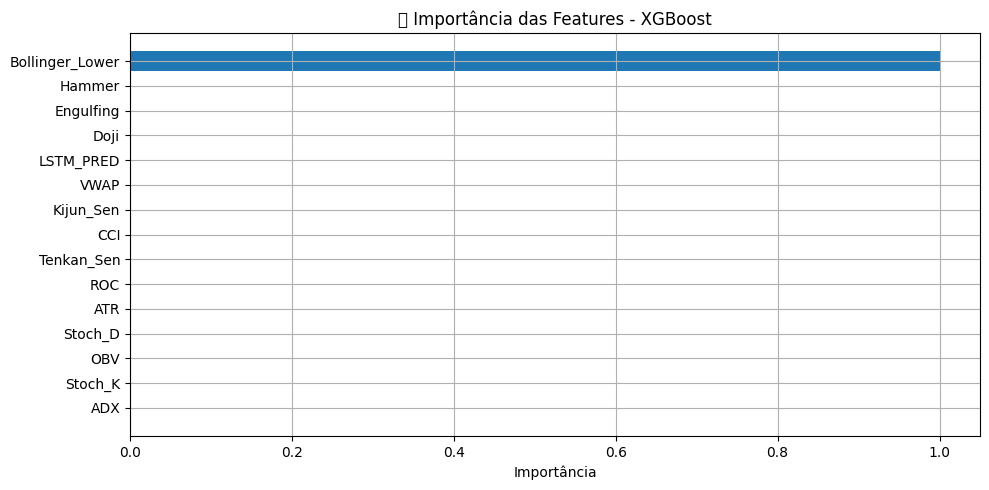

📂 Modelo LSTM carregado de: /content/models/lstm_model_BTCUSD_15m.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📨 Mensagem enviada com sucesso!
📨 Alerta enviado para o Telegram!


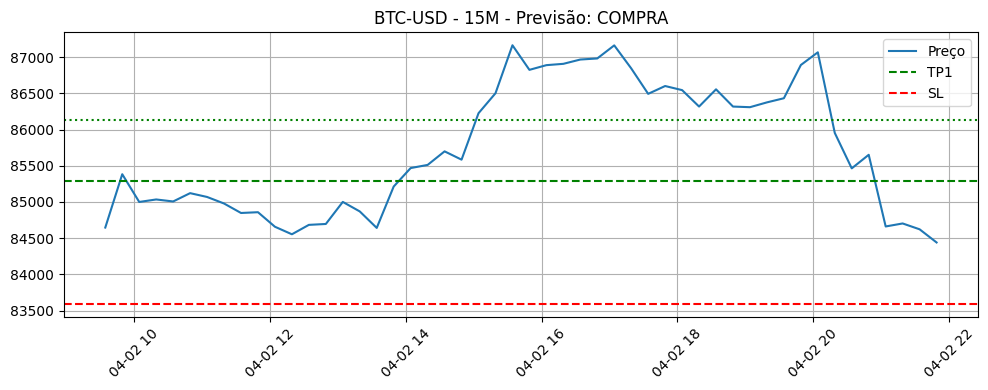


📁 Resultados salvos em: model_results_2025-04-02_21-49-15.csv
📋 Log de previsões atualizado em: /content/prediction_log.csv

✅ Backtest TP1 médio: +$844.41 por trade com confiança > 60%


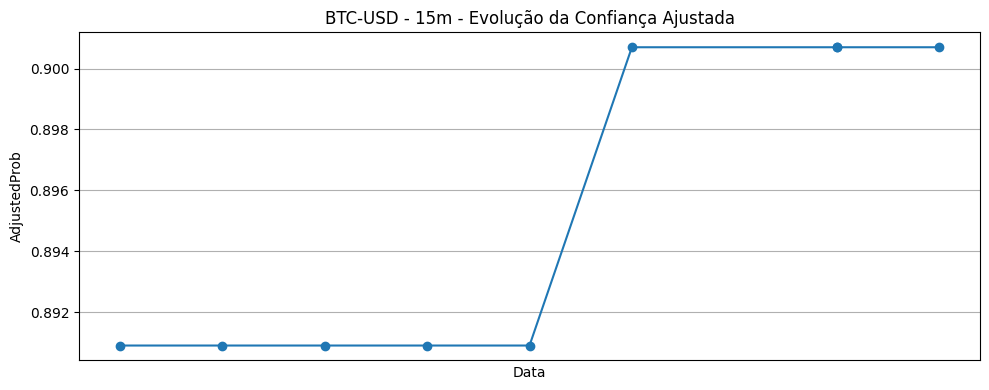

In [12]:
#Teste manual da análise de 15 minutos
run_analysis(
    selected_timeframes=[{"interval": "15m", "period": "30d", "atr": 0.02}],
    plot_timeframes=["15m"],
    alert_timeframes=["15m"]
)


📊 Total de previsões com valor previsto: 11


<ipython-input-13-17d242e32184>:639: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


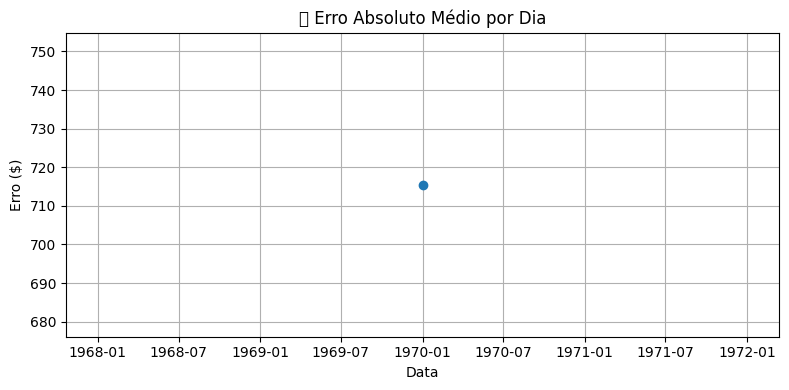

<ipython-input-13-17d242e32184>:652: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


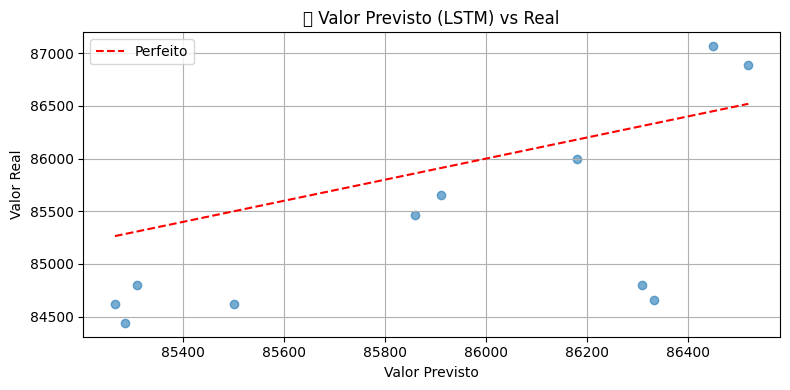

<ipython-input-13-17d242e32184>:662: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


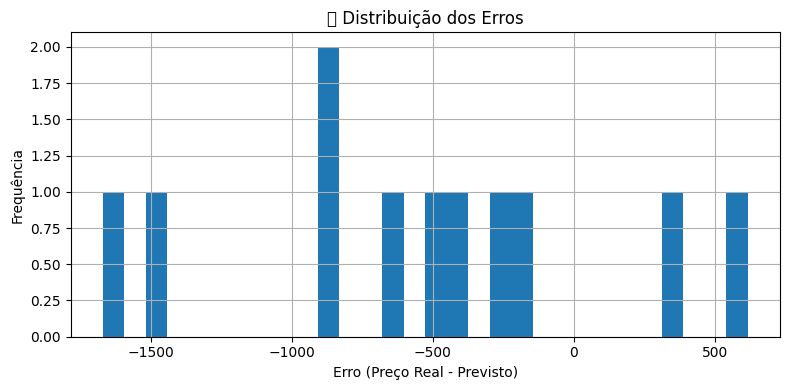

In [14]:
plot_prediction_performance("/content/prediction_log.csv")


📊 Total de previsões com valor previsto: 6


<ipython-input-2-74f3ea6e8775>:615: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


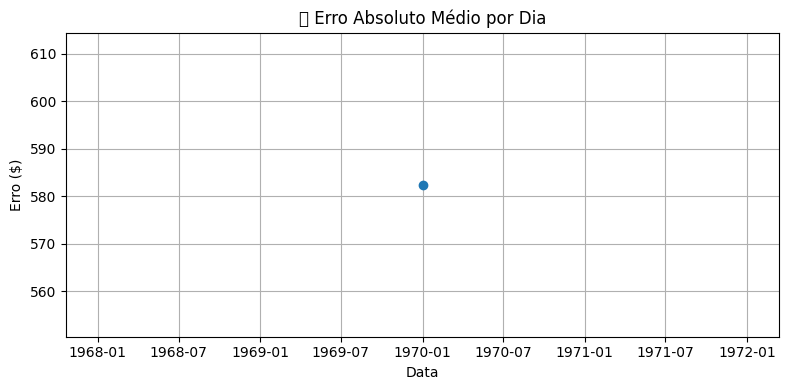

<ipython-input-2-74f3ea6e8775>:628: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


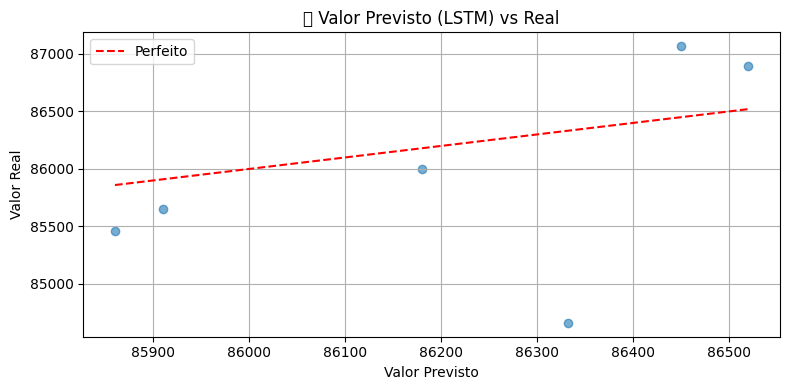

<ipython-input-2-74f3ea6e8775>:638: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


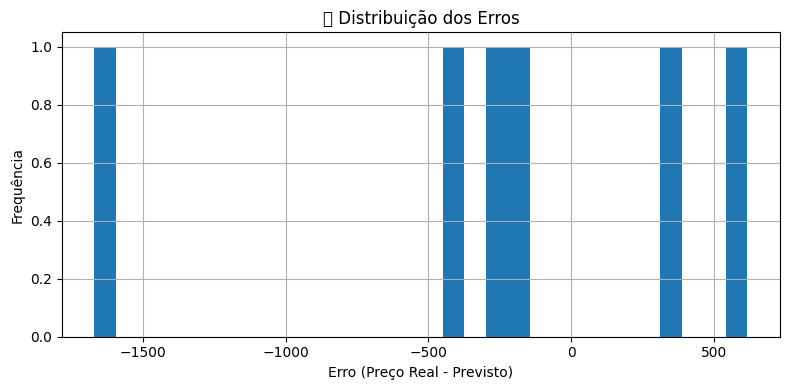

In [4]:
plot_prediction_performance()

In [3]:
df_simulados = simular_todos_trades()
plotar_evolucao_carteira()


NameError: name 'simular_todos_trades' is not defined